In [18]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm
import os
from sklearn.linear_model import LinearRegression
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statannotations.Annotator import Annotator

# statsmodels and sklearn are currently not used. Both packages can be omitted for now, but sklearn will
# very likely be used in the future

%matplotlib inline

# Folder containing the data file
data_dir = r'F:\OneDrive - med.cornell.edu\Documents\Photoacoustic_Placenta\Preeclampsia Model\RTG11\QUS_Processing_Andrew' # on desktop
data_dir = r'C:\Users\cah4016\OneDrive - med.cornell.edu\Documents\Photoacoustic_Placenta\Preeclampsia Model\RTG11\QUS_Processing_Andrew' # on laptop
data_dir = r'F:\OneDrive - med.cornell.edu\Documents\Photoacoustic_Placenta\IUS_2023' # For IUS 2023 abstract
data_dir = r'C:\Users\acm4005\Box\WCM_Tulane_Shared_Folder\Preeclampsia Model' # For UITC 2023 talk

# Name of the file containing the QUS results
data_fid = r'2023-03-07_GD14-18.csv'
data_fid = r'2023-05-25.csv'

# Define an array of the QUS parameter names. This will be useful later
qus_params = ['ESD','EAC','MBF','SS','I0','Naka Omega','Naka m','HK k','HK alpha']

# Move to the data folder and read the .csv into a DataFrame
os.chdir(data_dir)
in_data = pd.read_csv(data_fid)

# Rename the columns using abbreviations for the parameter names
new_names = {'HK Structure Param':'HK k','HK Scatterer Clustering Param':'HK alpha','Nak Shape Param':'Naka m','Nak Scale Factor':'Naka Omega', 
             'Spectral Slope':'SS','Intercept':'I0','Midband Fit':'MBF','Effective Scatterer Size':'ESD','Acoustic Concentration':'EAC'}
in_data.rename(new_names,axis=1,inplace=True)

# Convert ESD from m to um
in_data['ESD'] *= 1e6

# Log compress the Nakagami Omega and HK alpha parameters
in_data['Naka Omega'] = np.log10(in_data['Naka Omega'])
in_data['HK alpha'] = np.log10(in_data['HK alpha'])

# As a precaution, remove any rows that contain a NaN in any column
in_data.dropna(axis=0,inplace=True)

# Based on the ID string, split into new columns with ID, Day, and Frame #
in_data[['ID','Day','Frame']] = in_data['ID'].str.split('_',2,expand=True)

# Convert Day column into integer data type (instead of string)
in_data['Day'] = in_data['Day'].astype(int)

in_data_copy = in_data.copy()

# # Keep only the first 5 characters from the ID - the last specifies placenta (not animal) and is not needed at this time
# # This will make it easier to separate the control and treat groups
# in_data['ID'] = in_data['ID'].str[:5]

# Remove any rows where the ESD is zero 
# This means QUS estimation failed
remove_idx = (in_data['ESD'] <= 0)
in_data.drop(in_data.loc[remove_idx].index,inplace=True)

# Keep only the rows where the ROI was 13mm +/- 1mm in z-direction
# ZCoord specifies to top of the ROI. And the ROI z-length is 0.5mm
remove_idx = (in_data['ZCoord'] > .0135) | (in_data['ZCoord'] < .0115)
# remove_idx = (in_data['ZCoord'] > .0125) | (in_data['ZCoord'] < .0115)
in_data.drop(in_data.loc[remove_idx].index,inplace=True)

# The .csv contains a row for every ROI within the placenta boundaries in each frame.
# Compute the mean of the QUS parameters within each placenta
mean_data = in_data.groupby(['ID','Day'],as_index=False).mean()
std_data = in_data.groupby(['ID','Day'],as_index=False).std()
std_data = std_data[['ID','Day'] + qus_params]

# Drop the cases where too few ROIs are in the target range
count_df = in_data.groupby(['ID','Day'],as_index=False).count()
keep_ids = (count_df['HK k'] >= 30)
count_df = count_df.loc[keep_ids]
mean_data = pd.merge(left=mean_data,right=count_df[['ID','Day']],how='inner',on=['ID','Day'])

# All QUS parameters - this list will make life easier later
qus_params_std = [f'{qq}_std' for qq in qus_params]
std_rename = {f'{qq}':f'{qq}_std' for qq in qus_params} 
std_data.rename(std_rename,axis=1,inplace=True)

mean_data = pd.merge(left=mean_data,right=std_data,how='inner',on=['ID','Day'])

# Keep only the first 5 characters from the ID - the last specifies placenta (not animal) and is not needed at this time
# This will make it easier to separate the control and treat groups
mean_data['Pnum'] = mean_data['ID'].str[5:].astype(int)
mean_data['ID'] = mean_data['ID'].str[:5]

# Create a "Group" column to specify Control and RUPP animals
mean_data['Group'] = mean_data['ID']

# Rename the IDs to 'Control' and 'RUPP'
mean_data.loc[mean_data['ID'] == 'RTG11','Group'] = 'Control'
mean_data.loc[mean_data['ID'] == 'RTG36','Group'] = 'Control'
mean_data.loc[mean_data['ID'] == 'RTG37','Group'] = 'Control'
mean_data.loc[mean_data['ID'] == 'RTG43','Group'] = 'Control'
mean_data.loc[mean_data['ID'] == 'RTG34','Group'] = 'RUPP'
mean_data.loc[mean_data['ID'] == 'RTG44','Group'] = 'RUPP'



C:\Users\acm4005\AppData\Local\Temp\ipykernel_5588\3060467999.py:51: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  in_data[['ID','Day','Frame']] = in_data['ID'].str.split('_',2,expand=True)
C:\Users\acm4005\AppData\Local\Temp\ipykernel_5588\3060467999.py:75: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_data = in_data.groupby(['ID','Day'],as_index=False).mean()


In [19]:
p_orient = pd.read_csv("Placenta Orientation.csv")
p_data = pd.merge(left = p_orient, right = mean_data, how = 'inner',on = ['ID','Day','Pnum'])
mean_data = p_data.loc[p_data['Side Under'] != 1]
mean_data


,ID,Day,Pnum,Over,Side Over,Side Under,HK k,HK alpha,Naka m,Naka Omega,...,ESD_std,EAC_std,MBF_std,SS_std,I0_std,Naka Omega_std,Naka m_std,HK k_std,HK alpha_std,Group
1,RTG44,14,5,NaN,1.0,NaN,0.235069,0.906254,0.950059,6.198565,...,1.183608,1.161371,1.163102,0.133078,2.630556,0.090528,0.074298,0.204587,0.400452,RUPP
2,RTG11,16,3,NaN,1.0,NaN,0.191703,0.834376,0.908923,6.592632,...,1.864605,1.306695,1.194400,0.205854,4.914070,0.143696,0.090882,0.188801,0.593984,Control
3,RTG11,16,4,NaN,1.0,NaN,0.099653,0.825213,0.903552,6.372630,...,1.391887,0.947206,0.983724,0.139660,3.263706,0.088581,0.067178,0.168799,0.371544,Control
6,RTG34,16,3,NaN,1.0,NaN,0.270641,1.239906,0.972563,6.237238,...,0.872643,1.707277,1.713849,0.096192,3.393146,0.165873,0.077570,0.227749,0.623795,RUPP
9,RTG36,16,2,NaN,1.0,NaN,0.183472,0.638707,0.886173,6.135048,...,1.450541,2.299856,2.334531,0.161714,3.099029,0.130573,0.084341,0.169395,0.385936,Control
13,RTG37,16,3,NaN,1.0,NaN,0.072163,0.837699,0.892203,6.443538,...,2.234071,1.482688,1.539604,0.242226,4.550255,0.168180,0.058452,0.106483,0.383912,Control
17,RTG43,16,2,NaN,1.0,NaN,0.104513,0.717058,0.879089,6.309953,...,1.755852,1.560566,1.476137,0.195642,4.690822,0.192040,0.072028,0.133346,0.428380,Control
18,RTG43,16,3,1.0,NaN,NaN,0.151052,0.669449,0.896150,6.360057,...,1.520027,3.397067,3.420498,0.161583,3.672510,0.190561,0.060350,0.158512,0.325899,Control
22,RTG44,16,2,NaN,1.0,NaN,0.091165,1.150705,0.934188,6.210688,...,1.818160,1.752441,1.425046,0.213829,5.063048,0.130771,0.061509,0.162594,0.446248,RUPP
25,RTG11,18,1,NaN,1.0,NaN,0.351239,0.342103,0.902908,6.075398,...,1.969605,1.286468,1.767885,0.142778,4.276994,0.154183,0.133062,0.228227,0.432310,Control


In [20]:
keep_params = ['ID','Group','Day','Pnum'] + qus_params + [f'{qq}_std' for qq in qus_params]
summary_df = mean_data[keep_params]

save_str = r'.\_result_summary_by_placenta.xlsx'
# with pd.ExcelWriter(save_str,engine_kwargs={'options':{'strings_to_numbers':True}}) as writer:
#     summary_df.to_excel(writer)

In [21]:
summary_df

,ID,Group,Day,Pnum,ESD,EAC,MBF,SS,I0,Naka Omega,...,HK alpha,ESD_std,EAC_std,MBF_std,SS_std,I0_std,Naka Omega_std,Naka m_std,HK k_std,HK alpha_std
1,RTG44,RUPP,14,5,25.060476,113.072493,13.281893,-0.470875,22.228528,6.198565,...,0.906254,1.183608,1.161371,1.163102,0.133078,2.630556,0.090528,0.074298,0.204587,0.400452
2,RTG11,Control,16,3,24.543418,118.479584,18.655615,-0.419619,26.628373,6.592632,...,0.834376,1.864605,1.306695,1.194400,0.205854,4.914070,0.143696,0.090882,0.188801,0.593984
3,RTG11,Control,16,4,22.244062,117.047919,17.263366,-0.181607,20.713896,6.372630,...,0.825213,1.391887,0.947206,0.983724,0.139660,3.263706,0.088581,0.067178,0.168799,0.371544
6,RTG34,RUPP,16,3,23.366832,114.489725,14.837394,-0.271829,20.002137,6.237238,...,1.239906,0.872643,1.707277,1.713849,0.096192,3.393146,0.165873,0.077570,0.227749,0.623795
9,RTG36,Control,16,2,23.082396,116.803138,17.080738,-0.241021,21.660133,6.135048,...,0.638707,1.450541,2.299856,2.334531,0.161714,3.099029,0.130573,0.084341,0.169395,0.385936
13,RTG37,Control,16,3,24.269856,118.510721,18.635979,-0.376818,25.795530,6.443538,...,0.837699,2.234071,1.482688,1.539604,0.242226,4.550255,0.168180,0.058452,0.106483,0.383912
17,RTG43,Control,16,2,24.033638,114.887382,15.117028,-0.348216,21.733139,6.309953,...,0.717058,1.755852,1.560566,1.476137,0.195642,4.690822,0.192040,0.072028,0.133346,0.428380
18,RTG43,Control,16,3,22.501368,121.035370,21.259654,-0.177733,24.636590,6.360057,...,0.669449,1.520027,3.397067,3.420498,0.161583,3.672510,0.190561,0.060350,0.158512,0.325899
22,RTG44,RUPP,16,2,26.178298,115.628836,15.543541,-0.573725,26.444323,6.210688,...,1.150705,1.818160,1.752441,1.425046,0.213829,5.063048,0.130771,0.061509,0.162594,0.446248
25,RTG11,Control,18,1,17.458720,122.727396,20.941556,0.279186,15.637028,6.075398,...,0.342103,1.969605,1.286468,1.767885,0.142778,4.276994,0.154183,0.133062,0.228227,0.432310


In [22]:
mean_data

,ID,Day,Pnum,Over,Side Over,Side Under,HK k,HK alpha,Naka m,Naka Omega,...,ESD_std,EAC_std,MBF_std,SS_std,I0_std,Naka Omega_std,Naka m_std,HK k_std,HK alpha_std,Group
1,RTG44,14,5,NaN,1.0,NaN,0.235069,0.906254,0.950059,6.198565,...,1.183608,1.161371,1.163102,0.133078,2.630556,0.090528,0.074298,0.204587,0.400452,RUPP
2,RTG11,16,3,NaN,1.0,NaN,0.191703,0.834376,0.908923,6.592632,...,1.864605,1.306695,1.194400,0.205854,4.914070,0.143696,0.090882,0.188801,0.593984,Control
3,RTG11,16,4,NaN,1.0,NaN,0.099653,0.825213,0.903552,6.372630,...,1.391887,0.947206,0.983724,0.139660,3.263706,0.088581,0.067178,0.168799,0.371544,Control
6,RTG34,16,3,NaN,1.0,NaN,0.270641,1.239906,0.972563,6.237238,...,0.872643,1.707277,1.713849,0.096192,3.393146,0.165873,0.077570,0.227749,0.623795,RUPP
9,RTG36,16,2,NaN,1.0,NaN,0.183472,0.638707,0.886173,6.135048,...,1.450541,2.299856,2.334531,0.161714,3.099029,0.130573,0.084341,0.169395,0.385936,Control
13,RTG37,16,3,NaN,1.0,NaN,0.072163,0.837699,0.892203,6.443538,...,2.234071,1.482688,1.539604,0.242226,4.550255,0.168180,0.058452,0.106483,0.383912,Control
17,RTG43,16,2,NaN,1.0,NaN,0.104513,0.717058,0.879089,6.309953,...,1.755852,1.560566,1.476137,0.195642,4.690822,0.192040,0.072028,0.133346,0.428380,Control
18,RTG43,16,3,1.0,NaN,NaN,0.151052,0.669449,0.896150,6.360057,...,1.520027,3.397067,3.420498,0.161583,3.672510,0.190561,0.060350,0.158512,0.325899,Control
22,RTG44,16,2,NaN,1.0,NaN,0.091165,1.150705,0.934188,6.210688,...,1.818160,1.752441,1.425046,0.213829,5.063048,0.130771,0.061509,0.162594,0.446248,RUPP
25,RTG11,18,1,NaN,1.0,NaN,0.351239,0.342103,0.902908,6.075398,...,1.969605,1.286468,1.767885,0.142778,4.276994,0.154183,0.133062,0.228227,0.432310,Control


In [23]:
mean_data.groupby(['ID','Day']).count()

Pnum  Over  Side Over  Side Under  HK k  HK alpha  Naka m  \
ID    Day                                                              
RTG11 16      2     0          2           0     2         2       2   
      18      6     0          6           0     6         6       6   
RTG34 16      1     0          1           0     1         1       1   
      18      2     0          2           0     2         2       2   
RTG36 16      1     0          1           0     1         1       1   
      18      1     1          0           0     1         1       1   
RTG37 16      1     0          1           0     1         1       1   
      18      3     1          2           0     3         3       3   
RTG43 16      2     1          1           0     2         2       2   
      18      2     0          2           0     2         2       2   
RTG44 14      1     0          1           0     1         1       1   
      16      1     0          1           0     1         1       1   
      18      4     0          4           0     4         4       4   

           Naka Omega  SS  I0  ...  ESD_std  EAC_std  MBF_std  SS_std  I0_std  \
ID    Day                      ...                                              
RTG11 16            2   2   2  ...        2        2        2       2       2   
      18            6   6   6  ...        6        6        6       6       6   
RTG34 16            1   1   1  ...        1        1        1       1       1   
      18            2   2   2  ...        2        2        2       2       2   
RTG36 16            1   1   1  ...        1        1        1       1       1   
      18            1   1   1  ...        1        1        1       1       1   
RTG37 16            1   1   1  ...        1        1        1       1       1   
      18            3   3   3  ...        3        3        3       3       3   
RTG43 16            2   2   2  ...        2        2        2       2       2   
      18            2   2   2  ...        2        2        2       2       2   
RTG44 14            1   1   1  ...        1        1        1       1       1   
      16            1   1   1  ...        1        1        1       1       1   
      18            4   4   4  ...        4        4        4       4       4   

           Naka Omega_std  Naka m_std  HK k_std  HK alpha_std  Group  
ID    Day                                                             
RTG11 16                2           2         2             2      2  
      18                6           6         6             6      6  
RTG34 16                1           1         1             1      1  
      18                2           2         2             2      2  
RTG36 16                1           1         1             1      1  
      18                1           1         1             1      1  
RTG37 16                1           1         1             1      1  
      18                3           3         3             3      3  
RTG43 16                2           2         2             2      2  
      18                2           2         2             2      2  
RTG44 14                1           1         1             1      1  
      16                1           1         1             1      1  
      18                4           4         4             4      4  

[13 rows x 27 columns]

In [24]:
dd = mean_data.copy()
dd = dd[dd['Day'] == 18]
dd.groupby(['Group']).count()

in_data.drop(in_data.loc[remove_idx].index,inplace=True)

In [25]:
mean_data.head()

,ID,Day,Pnum,Over,Side Over,Side Under,HK k,HK alpha,Naka m,Naka Omega,...,ESD_std,EAC_std,MBF_std,SS_std,I0_std,Naka Omega_std,Naka m_std,HK k_std,HK alpha_std,Group
1,RTG44,14,5,NaN,1.0,NaN,0.235069,0.906254,0.950059,6.198565,...,1.183608,1.161371,1.163102,0.133078,2.630556,0.090528,0.074298,0.204587,0.400452,RUPP
2,RTG11,16,3,NaN,1.0,NaN,0.191703,0.834376,0.908923,6.592632,...,1.864605,1.306695,1.194400,0.205854,4.914070,0.143696,0.090882,0.188801,0.593984,Control
3,RTG11,16,4,NaN,1.0,NaN,0.099653,0.825213,0.903552,6.372630,...,1.391887,0.947206,0.983724,0.139660,3.263706,0.088581,0.067178,0.168799,0.371544,Control
6,RTG34,16,3,NaN,1.0,NaN,0.270641,1.239906,0.972563,6.237238,...,0.872643,1.707277,1.713849,0.096192,3.393146,0.165873,0.077570,0.227749,0.623795,RUPP
9,RTG36,16,2,NaN,1.0,NaN,0.183472,0.638707,0.886173,6.135048,...,1.450541,2.299856,2.334531,0.161714,3.099029,0.130573,0.084341,0.169395,0.385936,Control


In [26]:
p_stats = mean_data.groupby(['Group','Day']).agg([np.mean,np.std])
p_stats['EAC']

C:\Users\acm4005\AppData\Local\Temp\ipykernel_5588\2915751020.py:1: FutureWarning: ['ID'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  p_stats = mean_data.groupby(['Group','Day']).agg([np.mean,np.std])


mean       std
Group   Day                      
Control 16   117.794019  2.072538
        18   116.932779  3.844980
RUPP    14   113.072493       NaN
        16   115.059280  0.805473
        18   115.840840  1.847208

In [27]:
# Take the average of the placentas for each animal
p_avg = mean_data.groupby(['ID','Day'], as_index=False).mean()

p_avg

C:\Users\acm4005\AppData\Local\Temp\ipykernel_5588\855106950.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  p_avg = mean_data.groupby(['ID','Day'], as_index=False).mean()


,ID,Day,Pnum,Over,Side Over,Side Under,HK k,HK alpha,Naka m,Naka Omega,...,ZCoord,ESD_std,EAC_std,MBF_std,SS_std,I0_std,Naka Omega_std,Naka m_std,HK k_std,HK alpha_std
0,RTG11,16,3.50,NaN,1.0,NaN,0.145678,0.829795,0.906238,6.482631,...,0.013583,1.628246,1.126951,1.089062,0.172757,4.088888,0.116139,0.079030,0.178800,0.482764
1,RTG11,18,3.50,NaN,1.0,NaN,0.234522,0.746340,0.923762,6.210699,...,0.013499,2.037525,1.675203,1.846477,0.188120,4.827220,0.160932,0.085408,0.214042,0.413969
2,RTG34,16,3.00,NaN,1.0,NaN,0.270641,1.239906,0.972563,6.237238,...,0.012728,0.872643,1.707277,1.713849,0.096192,3.393146,0.165873,0.077570,0.227749,0.623795
3,RTG34,18,4.00,NaN,1.0,NaN,0.113771,0.825757,0.883183,6.102131,...,0.013988,1.733243,2.393131,2.356831,0.182892,4.746864,0.227065,0.091540,0.154009,0.502850
4,RTG36,16,2.00,NaN,1.0,NaN,0.183472,0.638707,0.886173,6.135048,...,0.013441,1.450541,2.299856,2.334531,0.161714,3.099029,0.130573,0.084341,0.169395,0.385936
5,RTG36,18,2.00,1.0,NaN,NaN,0.219110,0.897813,0.945465,5.967281,...,0.014163,1.490626,2.195378,2.303237,0.172479,2.466771,0.198606,0.059439,0.191761,0.467177
6,RTG37,16,3.00,NaN,1.0,NaN,0.072163,0.837699,0.892203,6.443538,...,0.013517,2.234071,1.482688,1.539604,0.242226,4.550255,0.168180,0.058452,0.106483,0.383912
7,RTG37,18,4.00,1.0,1.0,NaN,0.154896,0.776712,0.900559,5.993692,...,0.014459,1.803176,1.740577,1.903903,0.202482,4.384511,0.250209,0.083348,0.172689,0.442980
8,RTG43,16,2.50,1.0,1.0,NaN,0.127783,0.693254,0.887620,6.335005,...,0.013560,1.637939,2.478816,2.448318,0.178612,4.181666,0.191301,0.066189,0.145929,0.377140
9,RTG43,18,2.50,NaN,1.0,NaN,0.127168,0.729670,0.892485,5.869634,...,0.014307,1.906516,1.592219,1.523627,0.224870,4.180395,0.160508,0.063382,0.141886,0.312071


In [28]:
# Need to regroup the animals after averaging process because python can't take the average of a string.
p_avg['Group'] = p_avg['ID']

p_avg.loc[p_avg['ID'] == 'RTG11','Group'] = 'Control'
p_avg.loc[p_avg['ID'] == 'RTG36','Group'] = 'Control'
p_avg.loc[p_avg['ID'] == 'RTG37','Group'] = 'Control'
p_avg.loc[p_avg['ID'] == 'RTG43','Group'] = 'Control'
p_avg.loc[p_avg['ID'] == 'RTG34','Group'] = 'RUPP'
p_avg.loc[p_avg['ID'] == 'RTG44','Group'] = 'RUPP'

# Compute average and standard deviation across groups of animals
a_stats = p_avg.groupby(['Group','Day'],as_index=False).agg([np.mean,np.std])
a_stats['EAC']

C:\Users\acm4005\AppData\Local\Temp\ipykernel_5588\3818705119.py:12: FutureWarning: ['ID'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  a_stats = p_avg.groupby(['Group','Day'],as_index=False).agg([np.mean,np.std])


mean       std
Group   Day                      
Control 16   117.759746  0.711743
        18   115.682129  3.486052
RUPP    14   113.072493       NaN
        16   115.059280  0.805473
        18   115.831498  0.039637

<Axes: xlabel='EAC', ylabel='ESD'>

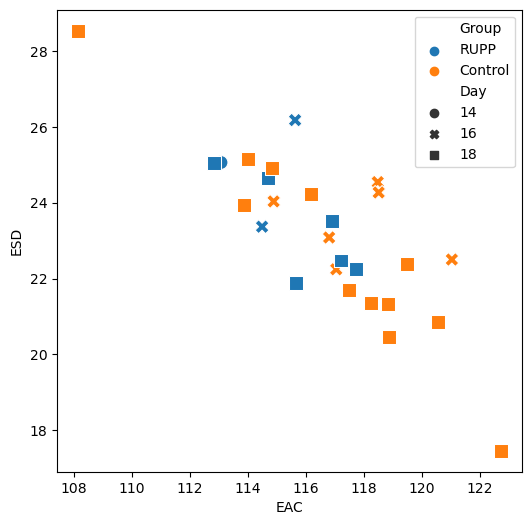

In [29]:
this_fig, this_ax = plt.subplots(1,1,figsize=(6,6))
sns.scatterplot(data=mean_data,x='EAC',y='ESD',hue='Group',style='Day',s=100)

<Axes: xlabel='ID', ylabel='ESD'>

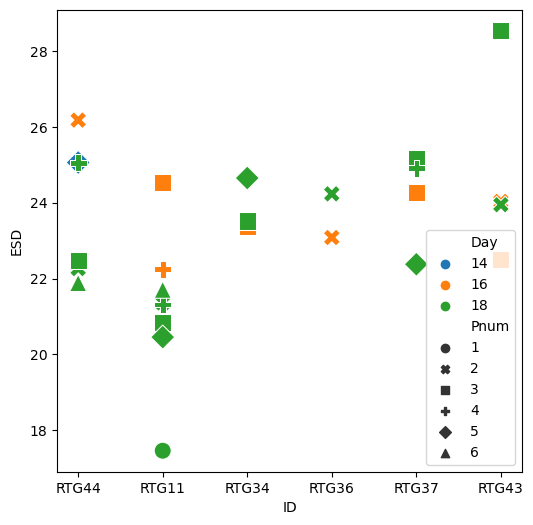

In [30]:
this_fig, this_ax = plt.subplots(1,1,figsize=(6,6))
sns.scatterplot(data=mean_data,x='ID',y='ESD',hue='Day',style='Pnum',ax=this_ax,s=150,palette='tab10')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

14_RUPP vs. 14_Control: Custom statistical test, P_val:1.860e-01
18_RUPP vs. 18_Control: Custom statistical test, P_val:1.200e-02
14_Control vs. 18_Control: Custom statistical test, P_val:5.000e-03
14_RUPP vs. 18_RUPP: Custom statistical test, P_val:8.280e-01


(array([16., 18., 20., 22., 24., 26., 28., 30., 32., 34.]),
 [Text(0, 16.0, '16'),
  Text(0, 18.0, '18'),
  Text(0, 20.0, '20'),
  Text(0, 22.0, '22'),
  Text(0, 24.0, '24'),
  Text(0, 26.0, '26'),
  Text(0, 28.0, '28'),
  Text(0, 30.0, '30'),
  Text(0, 32.0, '32'),
  Text(0, 34.0, '34')])

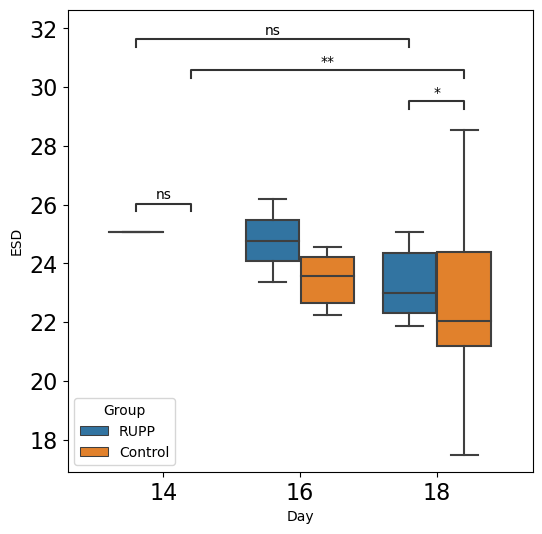

In [31]:
esd_df = mean_data[['Group','Day','ESD']]
comp_pairs = [[(14,'Control'),(14,'RUPP')],
              [(18,'Control'),(18,'RUPP')],
              [(14,'Control'),(18,'Control')],
              [(14,'RUPP'),(18,'RUPP')]]

p_values = [0.186, 0.012,0.005,0.828]

this_fig, this_ax = plt.subplots(1,1,figsize=(6,6))

hue_plot_params = {'data':esd_df,'x':'Day','y':'ESD','hue':'Group','palette':'tab10'}

sns.boxplot(ax=this_ax,**hue_plot_params)
annotator = Annotator(this_ax,comp_pairs,**hue_plot_params)
annotator.set_pvalues(p_values)
annotator.annotate()

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# this_fig.savefig(r'.\boxplot_esd_with_bars.tif',bbox_inches='tight',dpi=150)

ValueError: Missing hue value `Control` in ID (specified in `pairs`)

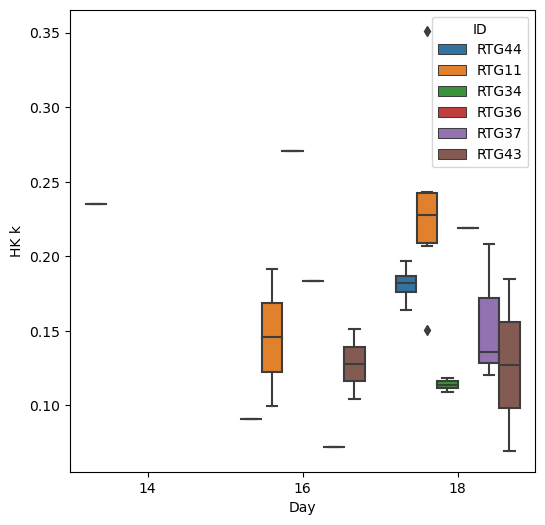

In [32]:
hkk_df = mean_data[['ID','Day','HK k']]
comp_pairs = [[(14,'Control'),(14,'RUPP')],
              [(18,'Control'),(18,'RUPP')],
              [(14,'Control'),(18,'Control')],
              [(14,'RUPP'),(18,'RUPP')]]

this_fig, this_ax = plt.subplots(1,1,figsize=(6,6))

hue_plot_params = {'data':hkk_df,'x':'Day','y':'HK k','hue':'ID','palette':'tab10'}

sns.boxplot(ax=this_ax,**hue_plot_params)
annotator = Annotator(this_ax,comp_pairs,**hue_plot_params)
annotator.set_pvalues(p_values)
annotator.annotate()

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

this_fig.savefig(r'.\boxplot_HKk_with_bars.tif',bbox_inches='tight',dpi=150)

ValueError: Missing hue value `Control` in ID (specified in `pairs`)

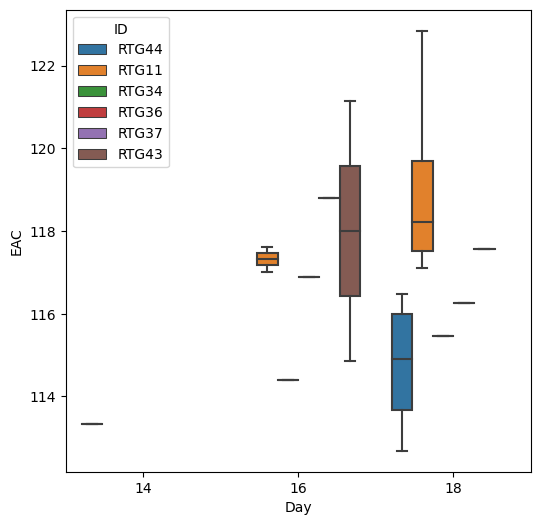

In [ ]:
eac_df = mean_data[['ID','Day','EAC']]
comp_pairs = [[(14,'Control'),(14,'RUPP')],
              [(18,'Control'),(18,'RUPP')],
              [(14,'Control'),(18,'Control')],
              [(14,'RUPP'),(18,'RUPP')]]

p_values = [0.186, 0.012,0.005,0.828]

this_fig, this_ax = plt.subplots(1,1,figsize=(6,6))

hue_plot_params = {'data':eac_df,'x':'Day','y':'EAC','hue':'ID','palette':'tab10'}

sns.boxplot(ax=this_ax,**hue_plot_params)
annotator = Annotator(this_ax,comp_pairs,**hue_plot_params)
annotator.set_pvalues(p_values)
annotator.annotate()

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

this_fig.savefig(r'.\boxplot_eac_with_bars.tif',bbox_inches='tight',dpi=150)

In [ ]:
mean_data.groupby(['ID','Day']).count()

HK k  HK alpha  Naka m  Naka Omega  SS  I0  MBF  ESD  EAC  \
ID      Day                                                              
Control 14      8         8       8           8   8   8    8    8    8   
        18     14        14      14          14  14  14   14   14   14   
RUPP    14      4         4       4           4   4   4    4    4    4   
        18      5         5       5           5   5   5    5    5    5   

             ROI Z Dist  ...  ZCoord  ESD_std  EAC_std  MBF_std  SS_std  \
ID      Day              ...                                              
Control 14            8  ...       8        8        8        8       8   
        18           14  ...      14       14       14       14      14   
RUPP    14            4  ...       4        4        4        4       4   
        18            5  ...       5        5        5        5       5   

             I0_std  Naka Omega_std  Naka m_std  HK k_std  HK alpha_std  
ID      Day                                                              
Control 14        8               8           8         8             8  
        18       14              14          14        14            14  
RUPP    14        4               4           4         4             4  
        18        5               5           5         5             5  

[4 rows x 22 columns]

In [ ]:
in_data.groupby(['ID','Day']).count()

HK k  HK alpha  Naka m  Naka Omega   SS   I0  MBF  ESD  EAC  \
ID     Day                                                                
RTG111 14     46        46      46          46   46   46   46   46   46   
       18    126       126     126         126  126  126  126  126  126   
RTG112 14     28        28      28          28   28   28   28   28   28   
       18    137       137     137         137  137  137  137  137  137   
RTG113 14     78        78      78          78   78   78   78   78   78   
       18     92        92      92          92   92   92   92   92   92   
RTG114 14     93        93      93          93   93   93   93   93   93   
       18    124       124     124         124  124  124  124  124  124   
RTG115 14     49        49      49          49   49   49   49   49   49   
       18    113       113     113         113  113  113  113  113  113   
RTG116 18    101       101     101         101  101  101  101  101  101   
RTG341 14     42        42      42          42   42   42   42   42   42   
       18     36        36      36          36   36   36   36   36   36   
RTG342 14     14        14      14          14   14   14   14   14   14   
       18     48        48      48          48   48   48   48   48   48   
RTG343 14     83        83      83          83   83   83   83   83   83   
       18    111       111     111         111  111  111  111  111  111   
RTG344 14     54        54      54          54   54   54   54   54   54   
       18     44        44      44          44   44   44   44   44   44   
RTG345 14     47        47      47          47   47   47   47   47   47   
       18     42        42      42          42   42   42   42   42   42   
RTG361 14     12        12      12          12   12   12   12   12   12   
       18    119       119     119         119  119  119  119  119  119   
RTG362 14     23        23      23          23   23   23   23   23   23   
       18    130       130     130         130  130  130  130  130  130   
RTG363 14     41        41      41          41   41   41   41   41   41   
       18     50        50      50          50   50   50   50   50   50   
RTG364 14     53        53      53          53   53   53   53   53   53   
       18    125       125     125         125  125  125  125  125  125   
RTG365 18    144       144     144         144  144  144  144  144  144   
RTG371 14     30        30      30          30   30   30   30   30   30   
       18     87        87      87          87   87   87   87   87   87   
RTG372 14      6         6       6           6    6    6    6    6    6   
       18    127       127     127         127  127  127  127  127  127   
RTG373 14     26        26      26          26   26   26   26   26   26   
       18     27        27      27          27   27   27   27   27   27   
RTG374 14     77        77      77          77   77   77   77   77   77   
       18      4         4       4           4    4    4    4    4    4   
RTG375 18    120       120     120         120  120  120  120  120  120   

            ROI Z Dist  XCoord  YCoord  ZCoord  Frame  
ID     Day                                             
RTG111 14           46      46      46      46     46  
       18          126     126     126     126    126  
RTG112 14           28      28      28      28     28  
       18          137     137     137     137    137  
RTG113 14           78      78      78      78     78  
       18           92      92      92      92     92  
RTG114 14           93      93      93      93     93  
       18          124     124     124     124    124  
RTG115 14           49      49      49      49     49  
       18          113     113     113     113    113  
RTG116 18          101     101     101     101    101  
RTG341 14           42      42      42      42     42  
       18           36      36      36      36     36  
RTG342 14           14      14      14      14     14  
       18           48      48      48  

In [ ]:
mean_data.groupby(['ID']).agg([np.max, np.min])['ZCoord']

,amax,amin
ID,,
Control,0.012756,0.012288
RUPP,0.013189,0.012359


In [ ]:
# Compute the independent samples t-test between placentas on days 14 and 18
# Also add the difference in the mean parameters values as day_18 - day_14
ttest_res = np.zeros((len(qus_params),3)) # numpy array to store the t-statistics and p-values
d14_df = mean_data[mean_data['Day'] == 14]
d18_df = mean_data[mean_data['Day'] == 18]

for q_idx, q_param in enumerate(qus_params):
    var_1 = d14_df[q_param]
    var_2 = d18_df[q_param]

    var_diff = np.mean(var_2) - np.mean(var_1)

    t_stat, p_value = scipy.stats.ttest_ind(var_1.values.reshape(-1,1),var_2.values.reshape(-1,1))

    ttest_res[q_idx] = [t_stat,p_value,var_diff]

ttest_df = pd.DataFrame(ttest_res,index=qus_params,columns=['t_val','p-value','Diff. of Means'])
# ttest_df.to_excel(r'.\_ttest_results_by_day_2023-3-29.xlsx')

save_str = r'.\_ttest_results_by_day_2023-3-29.xlsx'
# with pd.ExcelWriter(save_str,engine_kwargs={'options':{'strings_to_numbers':True}}) as writer:
#     ttest_df.to_excel(writer)

print(ttest_df)

               t_val       p-value  Diff. of Means
ESD         0.563468  5.754490e-01       -0.290622
EAC        -1.437949  1.562188e-01        1.138828
MBF        -1.255642  2.146520e-01        0.935529
SS         -0.728379  4.695285e-01        0.037124
I0         -0.290122  7.728345e-01        0.230173
Naka Omega -0.325571  7.460070e-01        0.018387
Naka m     -6.637903  1.594199e-08        0.132902
HK k       -5.290995  2.267926e-06        0.068799
HK alpha   -6.767637  9.820690e-09        0.298890


C:\Users\cah4016\AppData\Local\Temp/ipykernel_17492/1638869288.py:15: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  ttest_res[q_idx] = [t_stat,p_value,var_diff]


In [ ]:
df_list = []

test_df = mean_data[mean_data['Group'] == 'Control']
save_str = r'_paired_t-test_control_2023-3-29.xlsx'

# test_df = mean_data[mean_data['Group'] == 'RUPP']
# save_str = r'_paired_t-test_RUPP_2023_3_29.xlsx'


for q_idx, qp in enumerate(qus_params):

    this_tukey = pairwise_tukeyhsd(endog=test_df[qp],groups=test_df['Day'],alpha=0.05)
    this_data = this_tukey._results_table.data

    this_data = np.asarray(this_data)
    this_data = this_data[1:,:]

    # Create a list of tuples to act as a MultiIndex specifying the two Diagnosis groups being compared
    col_1 = this_data[:,0].tolist()
    col_2 = this_data[:,1].tolist()
    m_ind = m_ind = list(zip(col_1,col_2))
    m_ind = pd.MultiIndex.from_tuples(m_ind,names=['Group 1','Group 2'])
    this_series = pd.Series(this_data[:,3],index=m_ind,name=qp)

    df_list.append(this_series.copy())

master_df = pd.concat(df_list,axis=1)
master_df.reset_index(inplace=True)

print(master_df)

# with pd.ExcelWriter(save_str,engine_kwargs={'options':{'strings_to_numbers':True}}) as writer:
#     master_df.to_excel(writer)

  Group 1 Group 2     ESD     EAC     MBF      SS      I0 Naka Omega  Naka m  \
0      14      18  0.0065  0.0096  0.0259  0.0053  0.0575     0.5359  0.0248   

  HK k HK alpha  
0  0.0   0.0857  


In [ ]:
master_df.head()

,Group 1,Group 2,ESD,EAC,MBF,SS,I0,Naka Omega,Naka m,HK k,HK alpha
0,14,18,0.916,0.8279,0.8159,0.7647,0.9798,0.6284,0.1828,0.7822,0.0952


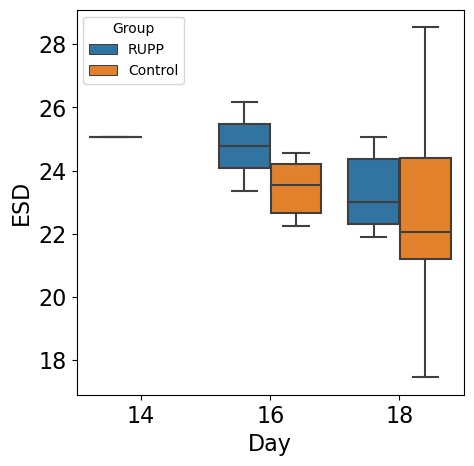

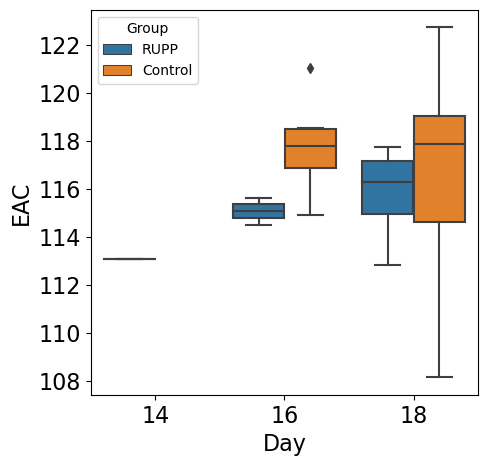

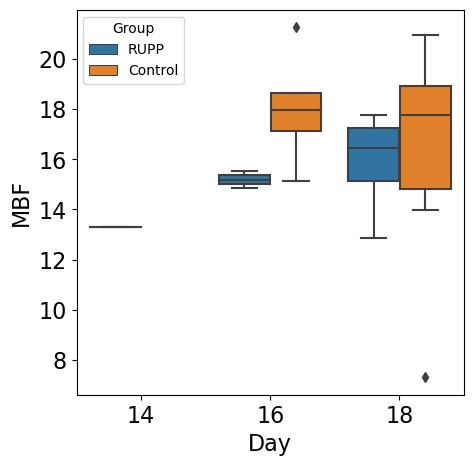

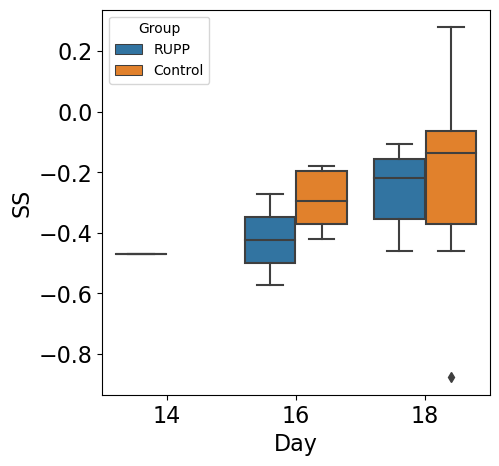

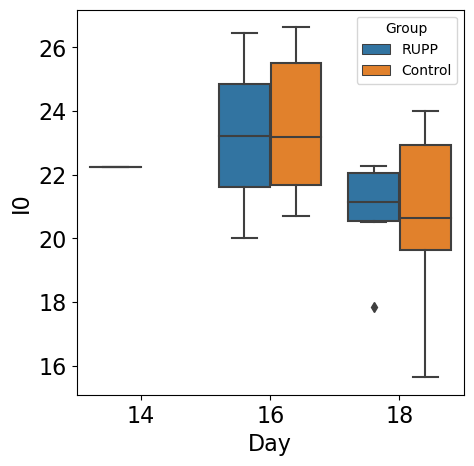

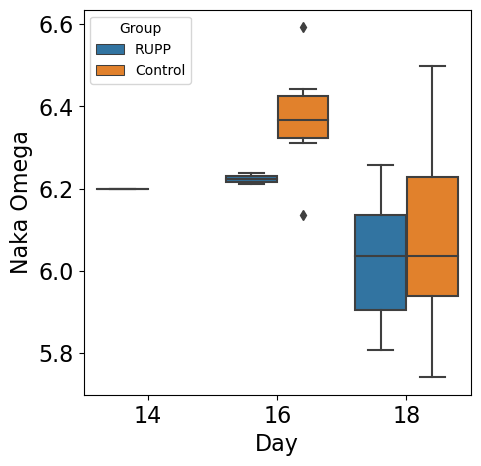

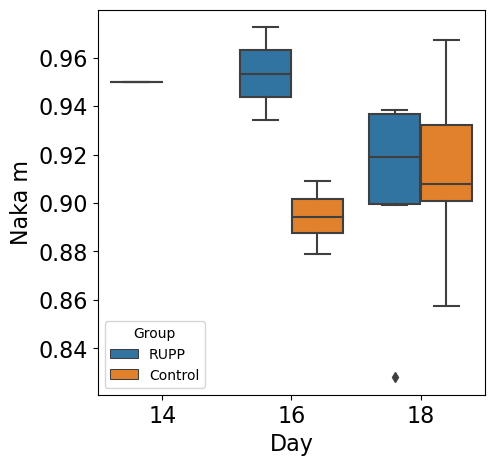

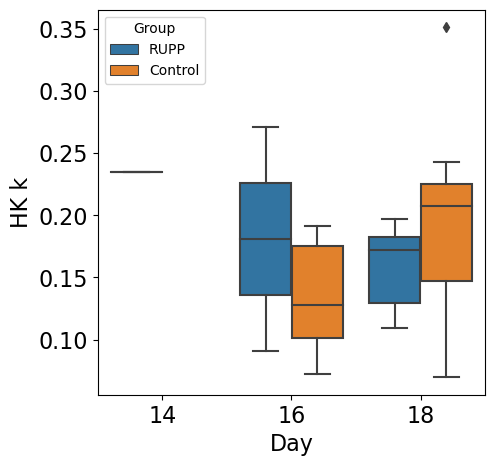

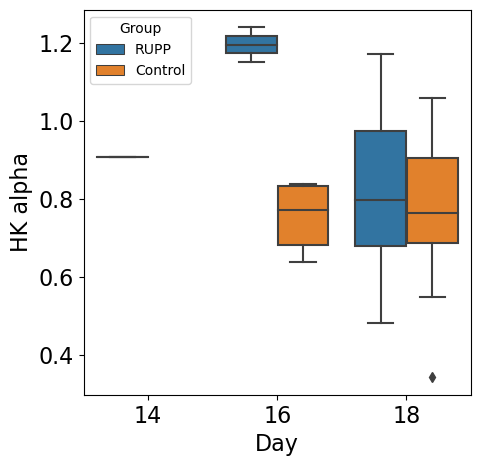

In [33]:
# Create box plots comparing the (mean) QUS parameters for all 3 days

save_folder = r'.\Boxplots_Mean_2023-3-29'

# if ~os.path.exists(save_folder):
    # os.mkdir(save_folder)

for q_idx, q_param in enumerate(qus_params):
    this_fig, this_ax = plt.subplots(1,1,figsize=(5,5))

    sns.boxplot(data=mean_data,x='Day',hue='Group',y=q_param,ax=this_ax,palette='tab10')
    # sns.stripplot(data=mean_data,x='Day',y=q_param,hue='ID',dodge=True,ax=this_ax,edgecolor='black',linewidth=1,palette='tab10')

    this_ax.set_xlabel(this_ax.get_xlabel(),fontsize=16)
    this_ax.set_ylabel(this_ax.get_ylabel(),fontsize=16)
    # this_ax.legend([],[],frameon=False)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    save_str = f'{save_folder}\\_{q_param}_boxplot.tif'
    # this_fig.savefig(save_str,bbox_inches='tight',dpi=150)

    

In [ ]:
os.path.exists(save_folder)

True

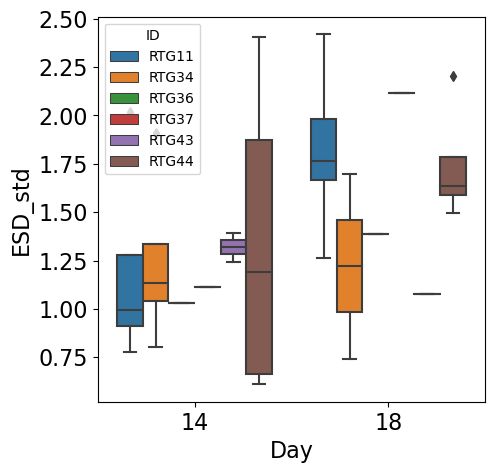

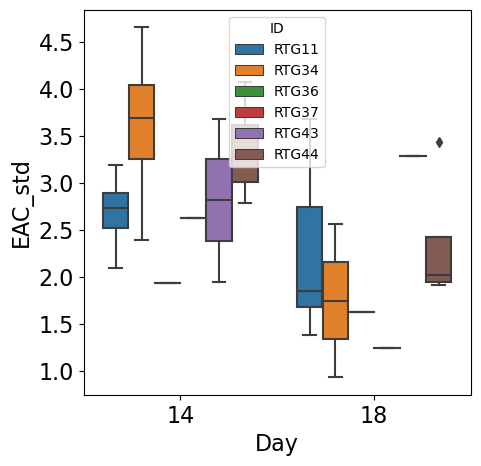

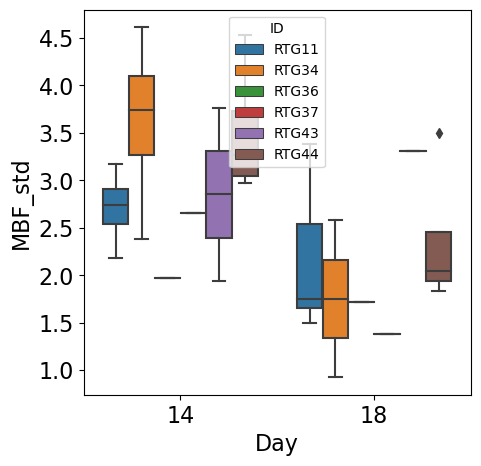

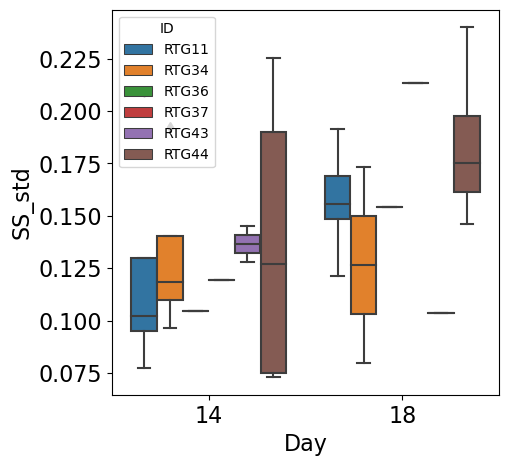

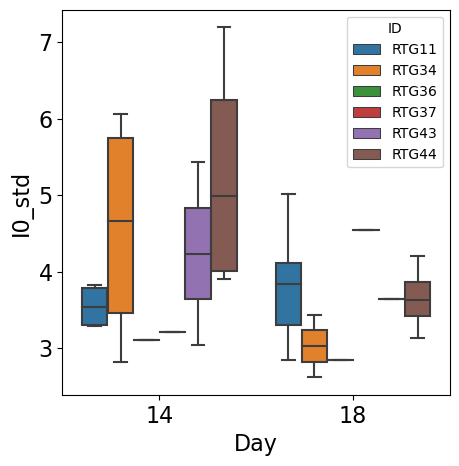

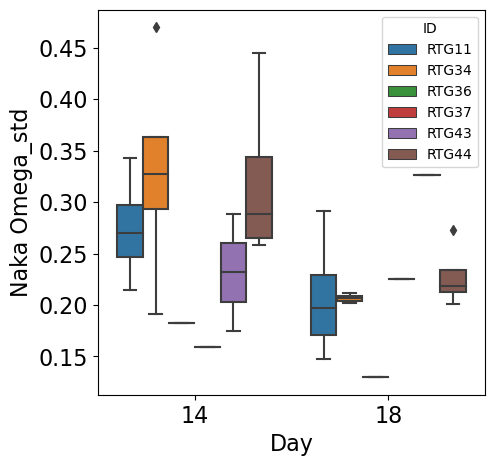

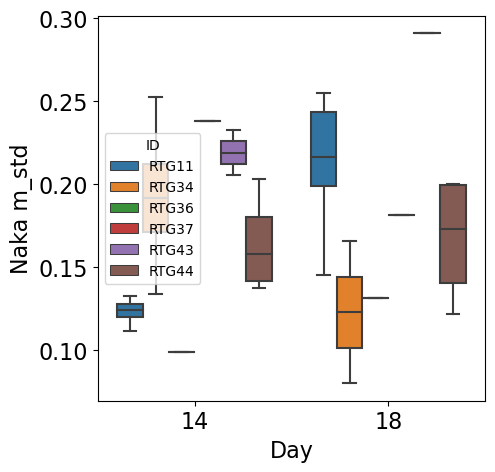

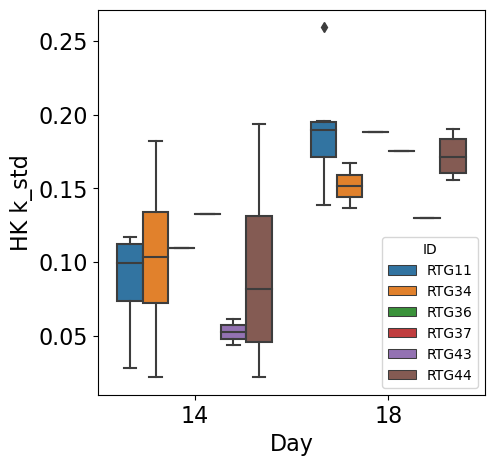

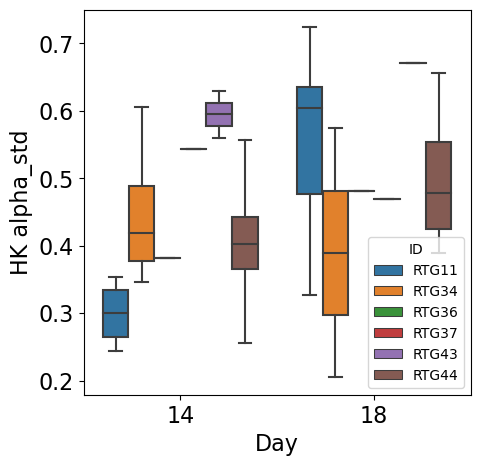

In [ ]:
# Create box plots comparing the (standard deviation) QUS parameters for all 3 days

save_folder = r'.\Boxplots_Std'

# if ~os.path.exists(save_folder):
#     os.mkdir(save_folder)

for q_idx, q_param in enumerate(qus_params_std):
    this_fig, this_ax = plt.subplots(1,1,figsize=(5,5))

    sns.boxplot(data=mean_data,x='Day',hue='ID',y=q_param,ax=this_ax,palette='tab10')
    # sns.stripplot(data=mean_data,x='Day',y=q_param,hue='ID',dodge=True,ax=this_ax,edgecolor='black',linewidth=1,palette='tab10')

    this_ax.set_xlabel(this_ax.get_xlabel(),fontsize=16)
    this_ax.set_ylabel(this_ax.get_ylabel(),fontsize=16)
    # this_ax.legend([],[],frameon=False)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    save_str = f'{save_folder}\\_{q_param}_boxplot.tif'
    # this_fig.savefig(save_str,bbox_inches='tight',dpi=150)

In [ ]:
# Compare the mean of parameter values between Control and RUPP for each day
all_days = [14,18]

p_mat = np.zeros((len(qus_params),len(all_days)))
diff_mat = np.zeros(p_mat.shape)

for d_idx, day in enumerate(all_days):
    sub_df = mean_data[mean_data['Day'] == day]

    for q_idx, param in enumerate(qus_params):
        var_c = sub_df[sub_df['Group'] == 'Control'][param]
        var_r = sub_df[sub_df['Group'] == 'RUPP'][param]

        var_c_mean = np.mean(var_c)
        var_r_mean = np.mean(var_r)

        this_t, this_p = scipy.stats.ttest_ind(var_c.values.reshape(-1,1),var_r.values.reshape(-1,1))

        p_mat[q_idx,d_idx] = this_p
        diff_mat[q_idx,d_idx] = var_r_mean - var_c_mean


p_df = pd.DataFrame(p_mat,index=qus_params,columns=all_days)
diff_df = pd.DataFrame(diff_mat,index=qus_params,columns=all_days)

print(p_df)
# with pd.ExcelWriter(r'.\_t-test_QUS_Mean_by_day.xlsx') as writer:
#     p_df.to_excel(writer)

# with pd.ExcelWriter(r'.\_t-test_QUS_MeanDiff_by_day.xlsx') as writer:
#     diff_df.to_excel(writer)

                  14        18
ESD         0.141203  0.018933
EAC         0.096479  0.004852
MBF         0.099681  0.005567
SS          0.151877  0.023568
I0          0.874560  0.288093
Naka Omega  0.141234  0.040302
Naka m      0.407774  0.192450
HK k        0.357093  0.079317
HK alpha    0.274007  0.066136


In [ ]:
# Compare the standard deviation of parameter values between Control and RUPP for each day
all_days = [14,16,18]

p_mat = np.zeros((len(qus_params),len(all_days)))
diff_mat = np.zeros(p_mat.shape)

for d_idx, day in enumerate(all_days):
    sub_df = mean_data[mean_data['Day'] == day]

    for q_idx, param in enumerate(qus_params_std):
        var_c = sub_df[sub_df['ID'] == 'Control'][param]
        var_r = sub_df[sub_df['ID'] == 'RUPP'][param]

        var_c_mean = np.mean(var_c)
        var_r_mean = np.mean(var_r)

        this_t, this_p = scipy.stats.ttest_ind(var_c.values.reshape(-1,1),var_r.values.reshape(-1,1))

        p_mat[q_idx,d_idx] = this_p
        diff_mat[q_idx,d_idx] = var_r_mean - var_c_mean


p_df = pd.DataFrame(p_mat,index=qus_params,columns=all_days)
diff_df = pd.DataFrame(diff_mat,index=qus_params,columns=all_days)
print(p_df)

# with pd.ExcelWriter(r'.\_t-test_QUS_STD_by_day.xlsx') as writer:
#     p_df.to_excel(writer)

# with pd.ExcelWriter(r'.\_t-test_QUS_STDDiff_by_day.xlsx') as writer:
#     diff_df.to_excel(writer)

            14  16  18
ESD        NaN NaN NaN
EAC        NaN NaN NaN
MBF        NaN NaN NaN
SS         NaN NaN NaN
I0         NaN NaN NaN
Naka Omega NaN NaN NaN
Naka m     NaN NaN NaN
HK k       NaN NaN NaN
HK alpha   NaN NaN NaN


In [ ]:
diff_df

,14,16,18
ESD,NaN,NaN,NaN
EAC,NaN,NaN,NaN
MBF,NaN,NaN,NaN
SS,NaN,NaN,NaN
I0,NaN,NaN,NaN
Naka Omega,NaN,NaN,NaN
Naka m,NaN,NaN,NaN
HK k,NaN,NaN,NaN
HK alpha,NaN,NaN,NaN
